This notebook allows to explore the results of predicting the `click_rate` from `source_article` to `target_article` using different models (Doc2Vec, Wikipedia2Vec, Smash-RNN Paragraph Level, Smash-RNN Sentence Level and Smash-RNN Word Level).

The class `ResultsAnalyzer` encapsules the logic to compute the results. Main features:
- `get_ndcg_for_all_models`: Calculates the Normalized Discounted Cumulative Gain for each model
- `get_map_for_all_models`: Calculates the Mean Average Precision for each model
- `get_top_5_predicted_by_article_and_model(source_article, model)`: Gets the top 5 predictions for the `source_article`. The column `is_in_top_5` shows if the `target_article` is in the **actual** top 5 click rate.
- `ResultsAnalyzer.results`: It is a Pandas Datafram containing the consolidated results
- `get_sample_source_articles`: Samples 10 random `source_articles`. Can be used to manually check the results

In [1]:
import pandas as pd
from results_analyzer import ResultsAnalyzer

results_analyzer = ResultsAnalyzer()

Getting NDCG for all models:

In [2]:
results = results_analyzer.calculate_statistics_per_group()

[2020-08-10 08:15:39,904] [INFO] Getting features from DB (calculate_statistics_per_group@results_analyzer.py:365)
[2020-08-10 08:15:55,715] [INFO] Getting predictions by model (calculate_statistics_per_group@results_analyzer.py:379)
[2020-08-10 08:15:55,730] [INFO] Calculating predictions for each model (get_predictions_by_model@results_analyzer.py:289)
100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
[2020-08-10 08:16:15,335] [INFO] Calculating results by model (calculate_statistics_per_group@results_analyzer.py:399)
100%|██████████| 474/474 [00:05<00:00, 92.35it/s]


In [45]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

WORD_COUNT_BIN = "word_count_bin"
WORD_COUNT_COLUMN = "word_count"
OUT_LINKS_BIN = "out_links_bin"
OUT_LINKS_COLUMN= "out_links_count"
IN_LINKS_BIN = "in_links_bin"
IN_LINKS_COLUMN = "in_links_count_column"
MODEL_COLUMN = "model"

selected_models = [
            "doc2vec_cosine",
            "doc2vec_no_sigmoid",
            "paragraph_no_sigmoid",
            "sentence_no_sigmoid",
            "wikipedia2vec_cosine",
            "wikipedia2vec_no_sigmoid",
            "word_no_sigmoid",
        ]



def get_performance_figure(
    results,
    models,
    feature_column,
    x_label,
    y_label=None,
    figsize=(13, 6),
    legend_columns_count=4,
    buckets_count=5,
    save_file_path=None,
):
    bin_column = f"{feature_column}_bin"
    bins = pd.qcut(results[feature_column], q=buckets_count)

    results[bin_column] = bins
    result_by_model = results.groupby([bin_column]).mean()[models]

    fig = plt.figure(figsize=figsize)

    ax = result_by_model.plot(
        kind="bar", ax=fig.gca(), rot=0, width=0.7, alpha=0.9, edgecolor=["black"],
    )

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.25, box.width, box.height * 0.75])

    ax.legend(
        ncol=legend_columns_count,
        loc="upper center",
        fancybox=True,
        shadow=False,
        bbox_to_anchor=(0.5, 1.2),
    )

    # Formats the x label as "(lower, upper]"
    ax.set_xticklabels(
        [f"({int(i.left)}, {int(i.right)}]" for i in bins.cat.categories]
    )

    y_label = "NDCG@k (k=5)"
    ax.set_xlabel(x_label % len(result_by_model))
    ax.set_ylabel(y_label)

    if save_file_path:
        pdf_dpi = 300

        logger.info(f"Saved to {save_file_path}")
        plt.savefig(save_file_path, bbox_inches="tight", dpi=pdf_dpi)

    plt.show()

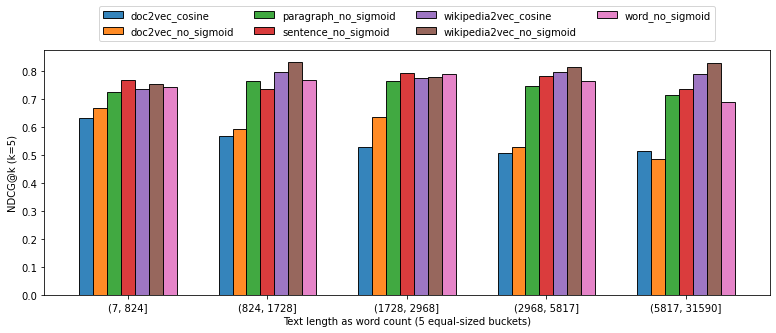

In [49]:
get_performance_figure(results, selected_models, WORD_COUNT_COLUMN, "Text length as word count (%s equal-sized buckets)")
# results

In [ ]:
models = ["wikipedia2vec_no_sigmoid", "word_no_sigmoid"]
get_performance_figure(ndcg_by_model_and_article, models, WORD_COUNT_COLUMN, 'Text length as word count (%s equal-sized buckets)')

In [ ]:
results_analyzer.get_map_for_all_models()

Getting a sample of the results

In [ ]:
results_analyzer.results.sample(n=10)

Getting a sample of the source articles

In [ ]:
results_analyzer.get_sample_source_articles()

Getting all the available models (models `paragraph`, `sentence` and `word` refer to Smash-RNN levels.)

In [ ]:
results_analyzer.get_models()

Getting the top 5 predictions for a `source_article` and a `model`

In [ ]:
sample_source_article = "Ireland"
model = "wikipedia2vec"

results_analyzer.get_top_10_predicted_by_article_and_model(sample_source_article, model)

Next steps:
- Create some analytics to understand better the results for each model (I will need help here!)